# QuanvNN
The original paper is `[Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits](https://arxiv.org/pdf/1904.04767)`.

The following explanation is what I believe, so please freely contact me about anything on the codes or the description below.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set paths in order to import packages correctly.
import sys
import os
sys.path.append(os.path.abspath("./../..")) 
sys.path.append("./../../src")

import src.utils as utils
utils.fix_seed(901)

## General Idea
Quanvolutional Neural Network (QuanvNN) is a classical neural network with quanvolutional layers. In the original paper, the authors suggested the quanvolutional layer as a layer having an arbitrary number of quantum circuits, called the quanvolutional filters, as an alternative to the classical convolutional layer. The quanvolutional layer is constructed as a random quantum circuit. The users can use the quanvolutional layer by specifying the kernel size and the number of filters. The general concept of the procudure through the quanvolutional layer is as follows;

1. Encode the data to the qubits of each quanvolutional filter.
2. Execute the filter.
3. Decode the outcomes of each filter.

The encoding and decoding methods are up to the user, however, certain methods are demonstrated in the original paper. Also, in the original paper, the quanvolutional layer is introduced as a non-trainable layer. My implementation of the quanvolutional layer is, for now, also non-trainable.

In [3]:
# Let's see the simple example of the quanvolutional layer.
from src.quanv_nn.quanv_layer import QuanvLayer

# Create the quanvolutional layer.
kernel_size = (2, 2)
num_filters = 2
quanv_layer = QuanvLayer(kernel_size=kernel_size, num_filters=num_filters)

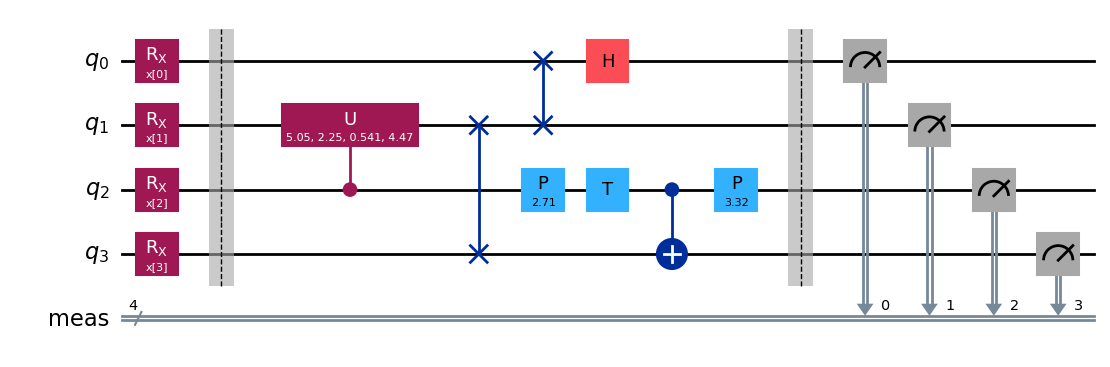

In [4]:
# See the first filter.
quanv_layer.filters[0].decompose().draw("mpl")

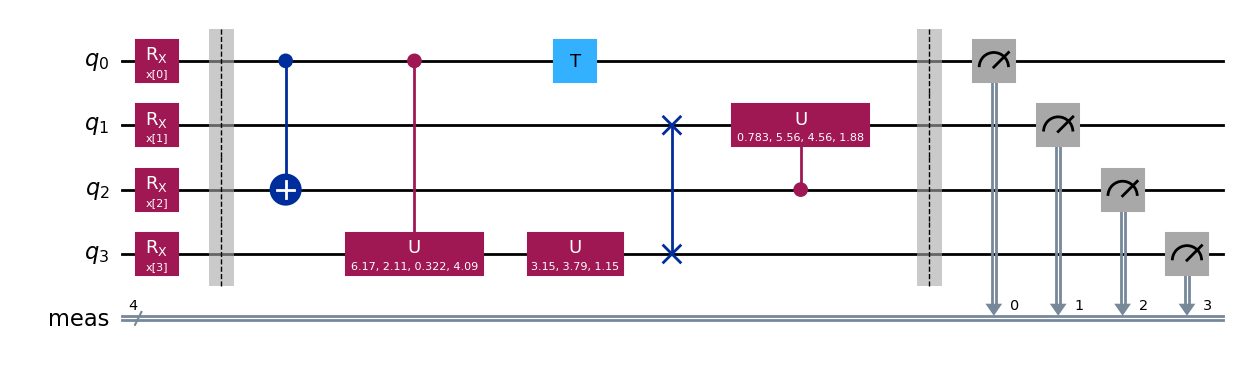

In [5]:
# See the second filter.
quanv_layer.filters[1].decompose().draw("mpl")

As we can see, the encoding method in my implementation is the angle encoding using the $RX$ gates. In the original paper, the authors demonstrate the power of quanvolutional neural networks using threshold encoding method: Encode each data point to each qubit as either `|0>` or `|1>` according to a threshold. Note that, the $RX(\pi)$ is the same as the $X$ gate excluding the global phase.

In my implementation of `QuanvLayer`, the decoding method is fixed, which is the same way of the original paper. The method outputs a scalar, which is the number of zeros, in the bitstring of the most likely outcome.

In [6]:
import numpy as np

# Make random data.
num_qubits = kernel_size[0] * kernel_size[1]
batch_size = 10
random_data = np.random.randint(low=0, high=2, size=(batch_size, num_qubits)) * np.pi

# Process the data
quanv_layer(random_data)

array([[2., 3., 1., 3., 1., 3., 2., 2., 2., 1.],
       [1., 1., 3., 2., 2., 2., 2., 3., 2., 1.]])

The above output does not have any practical meanings, yet QuanvLayer can process a data. The outout shape is `(num_filters, batch_size)`.

## My `QuanvNN` Class
My implementation of `QuanvNN` class is a child class of `torch.nn.Module`. The model architecture is simple; the first layer is the quanvolutional layer and then the other `torch.nn.Module`, which is given as an argument of `__init__`.

In [7]:
# Make a classical part.
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

class ClassicalCNN(nn.Module):
    """Classical CNN class."""

    def __init__(self, in_dim: list[int, int, int], num_classes: int):
        super().__init__()
        # Set the first convolutional layer.
        self.conv1 = nn.Conv2d(
            in_channels=in_dim[0],
            out_channels=50,
            kernel_size=(3, 3)
        )

        # Set the first pooling layer.
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=1)

        # Set the second convolutional layer.
        self.conv2 = nn.Conv2d(
            in_channels=50,
            out_channels=64,
            kernel_size=(3, 3),
        )

        # Set the second pooling layer.
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=1)

        # Set the first fully connected layer.
        self.fc1_input_size = (
            576
        )
        self.fc1_output_size = 1024
        self.fc1 = nn.Linear(
            in_features=self.fc1_input_size, out_features=self.fc1_output_size
        )

        # Set the dropout layer.
        self.dropout = nn.Dropout(p=0.4)

        # Set the second fully connected layer.
        self.fc2 = nn.Linear(
            in_features=self.fc1_output_size, out_features=num_classes
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward data.

        :param torch.Tensor x: input data
        :return torch.Tensor: processed data
        """
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        # Transform the output shape to input the fully connected layer.
        x = x.view(x.size()[0], -1)
        # print(len(x[0]))

        x = self.fc1(x)
        x = self.dropout(x)

        x = self.fc2(x)

        return F.softmax(x, dim=1)

In [8]:
from src.quanv_nn.quanv_nn import QuanvNN
classical_cnn = ClassicalCNN((1 * num_filters, 9, 9), 2)
quanv_nn = QuanvNN(quanv_layer=quanv_layer, classical_model=classical_cnn)
quanv_nn

QuanvNN(
  (classical_model): ClassicalCNN(
    (conv1): Conv2d(2, 50, kernel_size=(3, 3), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(50, 64, kernel_size=(3, 3), stride=(1, 1))
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=576, out_features=1024, bias=True)
    (dropout): Dropout(p=0.4, inplace=False)
    (fc2): Linear(in_features=1024, out_features=2, bias=True)
  )
)

`QuanvLayer` class is not a child class of `torch.nn.Model`, so `QuanvNN` class does not show `QuanvLayer` above.

The number of 'vertical': 16


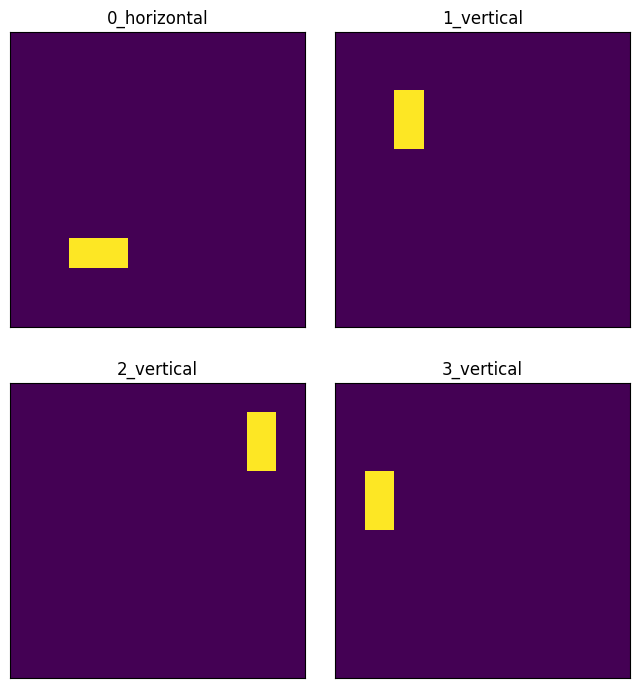

In [9]:
import matplotlib.pyplot as plt
from src.dataset import get_hor_ver

# Prepare the data.
min_noise_value = max_noise_value = 0
line_pixel_value = np.pi
num_images = 32
images, labels_str = get_hor_ver(num_images=num_images, image_shape=(10, 10),
                                 min_noise_value=min_noise_value,
                                 max_noise_value=max_noise_value,
                                 line_pixel_value=line_pixel_value)
images = images.reshape(num_images, 1, 10, 10)
correct_labels = ["vertical", "horizontal"]
labels = [int(label == "horizontal") for label in labels_str]
print(f"The number of 'vertical': {np.sum([label == 0 for label in labels])}")

# Check the data.
fig, ax = plt.subplots(2, 2, figsize=(8, 9), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        images[i].reshape(10, 10),
        aspect="equal",
    )
    ax[i // 2, i % 2].set_title(f"{i}_{labels_str[i]}")
plt.subplots_adjust(wspace=0.1, hspace=0.025)

See the accuracy before training the model.

In [10]:
%%time

shots = 32768

predicted_labels = quanv_nn.classify(torch.Tensor(images), shots=shots)
correct = 0
for index, predicted_label in enumerate(predicted_labels):
    print(f"{index}: True: {labels_str[labels[index]]} vs Classified: {labels_str[predicted_label]}")
    # print(f"{index}: True: {labels_str[index]} vs Classified: {labels_str[predicted_index]}")
    if labels_str[labels[index]] == labels_str[predicted_label]:
        correct += 1
accuracy = correct / len(images)
print(accuracy)

0: True: vertical vs Classified: horizontal
1: True: horizontal vs Classified: vertical
2: True: horizontal vs Classified: vertical
3: True: horizontal vs Classified: vertical
4: True: vertical vs Classified: vertical
5: True: vertical vs Classified: horizontal
6: True: vertical vs Classified: horizontal
7: True: vertical vs Classified: horizontal
8: True: horizontal vs Classified: vertical
9: True: horizontal vs Classified: vertical
10: True: vertical vs Classified: horizontal
11: True: vertical vs Classified: horizontal
12: True: vertical vs Classified: vertical
13: True: horizontal vs Classified: horizontal
14: True: vertical vs Classified: horizontal
15: True: vertical vs Classified: vertical
16: True: horizontal vs Classified: horizontal
17: True: horizontal vs Classified: vertical
18: True: vertical vs Classified: vertical
19: True: horizontal vs Classified: horizontal
20: True: horizontal vs Classified: vertical
21: True: horizontal vs Classified: horizontal
22: True: vertical v

Make two datasets for training and evaluating the `QuanvNN`.

In [11]:
# Separate the iamges.
from src.quanv_nn.train import preprocess_dataset
train_data, train_labels, val_data, val_labels = preprocess_dataset(
    data=images, labels=labels, encoding_method=lambda x: x, train_size=0.75, seed=901, shuffle=True
)  # encoding_method should be appropriate one, but this case, the images themselves were nicely prepared,
   # so we specify it as the identity function.

# Make the data loaders.
from src.plain_dataset import PlainDataset

train_dataset = PlainDataset(torch.Tensor(train_data), torch.Tensor(train_labels).type(torch.LongTensor))
val_dataset = PlainDataset(torch.Tensor(val_data), torch.Tensor(val_labels).type(torch.LongTensor))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)

Before actually starting to train the model, build look-up tables to cut the time of processing data through `QuanvLayer`.

In [12]:
import itertools

# Make all possibly input patterns.
pattern = [0, line_pixel_value]
all_patterns = np.array(
    list(itertools.product(pattern, repeat=quanv_nn.quanv_layer.num_qubits))
)

# Build the look-up tables.
quanv_nn.quanv_layer.build_lookup_tables(patterns=all_patterns)

Train the model. For a later check, show the total training time.

In [13]:
%%time
from src.torch_trainer import TorchTrainer

torch_trainer = TorchTrainer(model=quanv_nn)
epochs = 25
torch_trainer.train_and_eval(train_loader=train_loader, validation_loader=val_loader, epochs=epochs)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 7min 30s, sys: 13.7 s, total: 7min 44s
Wall time: 6min 54s


As the output cell shows, the loss and accuracy values went down and up, respectively, which means the learning process nicely proceeded.

Check the accuracy. Also, we can see how faster it is than processing data before building the look-up tables.

In [14]:
%%time

predicted_labels = quanv_nn.classify(torch.Tensor(images), shots=shots)
correct = 0
for index, predicted_label in enumerate(predicted_labels):
    print(f"{index}: True: {labels_str[labels[index]]} vs Classified: {labels_str[predicted_label]}")
    if labels_str[labels[index]] == labels_str[predicted_label]:
        correct += 1
accuracy = correct / len(images)
print(accuracy)

0: True: vertical vs Classified: vertical
1: True: horizontal vs Classified: horizontal
2: True: horizontal vs Classified: horizontal
3: True: horizontal vs Classified: horizontal
4: True: vertical vs Classified: vertical
5: True: vertical vs Classified: vertical
6: True: vertical vs Classified: horizontal
7: True: vertical vs Classified: vertical
8: True: horizontal vs Classified: horizontal
9: True: horizontal vs Classified: horizontal
10: True: vertical vs Classified: vertical
11: True: vertical vs Classified: vertical
12: True: vertical vs Classified: vertical
13: True: horizontal vs Classified: horizontal
14: True: vertical vs Classified: vertical
15: True: vertical vs Classified: vertical
16: True: horizontal vs Classified: horizontal
17: True: horizontal vs Classified: horizontal
18: True: vertical vs Classified: vertical
19: True: horizontal vs Classified: horizontal
20: True: horizontal vs Classified: horizontal
21: True: horizontal vs Classified: horizontal
22: True: vertical

## Note on the implementation of `QuanvLayer`
My implementation of `QuanvLayer` does not include the encoding, i.e., a given data is encoded into either `|0>` or `{1>` according to each value in the original paper. However, in this implementation, `QuanvLayer` includes only the `RX` gates applied to each qubit. Thus, if one would like to the same encoding method as the original paper, then the input data are needed to be encoding into either `0` or `\pi` before fed into the `QuanvLayer` or `QuanvNN`.